In [37]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable, Any
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [38]:
from problems import Burgers
problem = Burgers()

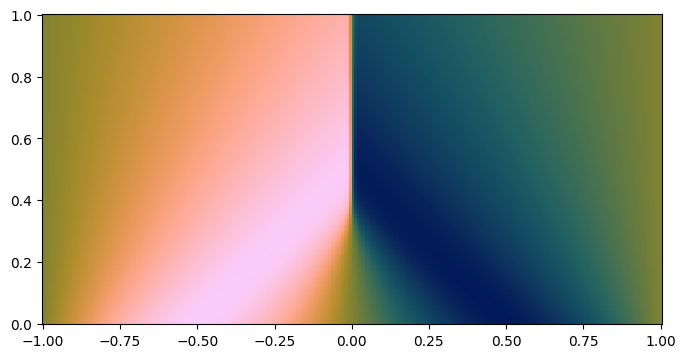

In [39]:
X, T, u_solution = problem.exact_solution(nx=256, nt=256)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

In [267]:
# @partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, key):
    key, subkey = jax.random.split(key)

    def residual_fn_for_optimizer(p, x):
        rebuilt_model = eqx.combine(p, static_parts)
        # Corrected call without jnp.expand_dims
        return problem.physics_residual(rebuilt_model, x)

    loss, updates, new_opt_state, metrics = optimiser.update(
        params, opt_state, residual_fn_for_optimizer, collocation_points
    )
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics, key

@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def resample_rad(
    model, candidate_points, n_points_to_sample, problem, k, c, key
):
    # 1. Calculate PDE residuals for all candidate points
    vmapped_residual_fn = jax.vmap(problem.physics_residual, in_axes=(None, 0))
    residuals = vmapped_residual_fn(model, candidate_points)
        
    # 2. Compute sampling probability based on the RAD formula
    epsilon_k = jnp.abs(residuals)**k
    weights = (epsilon_k / jnp.mean(epsilon_k)) + c
    probs = weights / jnp.sum(weights)

    # 3. Sample new points based on the calculated probabilities
    indices = jax.random.choice(
        key,  a=candidate_points.shape[0], shape=(n_points_to_sample,), p=probs, replace=False
    )
    
    return candidate_points[indices]

In [242]:
key = jax.random.PRNGKey(42)

layer_sizes = [2, 20, 20, 20, 20, 1]

model_key, sample_key = jax.random.split(key, 2)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()

start_time = time.monotonic()

epoch = 0

<function matplotlib.pyplot.show(close=None, block=None)>

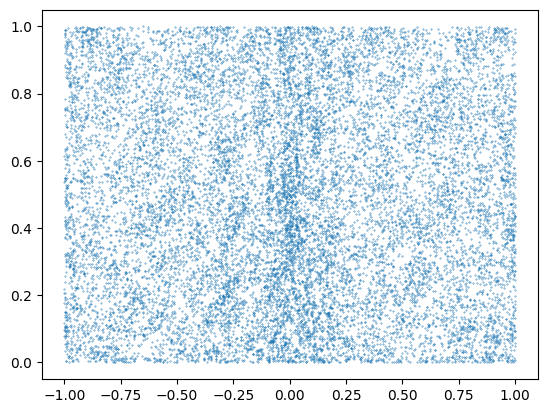

In [268]:
model = eqx.combine(params, static) 

# --- New Hyperparameters for RAD ---
resample_every_n_epochs = 1
rad_k = 1.0
rad_c = 1.0

n_collocation_points = 2**14
n_candidate_points = 20 * n_collocation_points

from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=2, seed=1)
samples = sampler.random(n=n_candidate_points)
l_bounds = [-1, 0]
u_bounds = [1, 1]
scaled_samples = qmc.scale(samples, l_bounds, u_bounds)
candidate_points = jnp.array(scaled_samples)
sample_key, subkey = jax.random.split(sample_key, 2)
collocation_points = resample_rad(
    model, 
    candidate_points, 
    n_collocation_points, 
    problem,
    rad_k,
    rad_c,
    subkey
)
    
plt.scatter(collocation_points[:, 0], collocation_points[:, 1], s=0.1)
plt.show

In [291]:
import jax
import jax.numpy as jnp
import equinox as eqx
from jax.flatten_util import ravel_pytree
from jaxopt import ScipyMinimize
from typing import Callable

# Define the state class using eqx.Module
class ScipyBFGSOptState(eqx.Module):
    params: eqx.Module

class ScipyBFGSOptimizer:
    def __init__(self, method: str = 'BFGS', tol=1e-6, maxiter=100):
        self.method = method
        self.tol = tol
        self.maxiter = maxiter
    
    def init(self, params: eqx.Module):
        return ScipyBFGSOptState(params=params)

    def update(
        self,
        params: eqx.Module,
        state: ScipyBFGSOptState,
        residual_fn: Callable[[eqx.Module, jax.Array], jax.Array],
        collocation_points
    ):
        def loss_fn(p_tree):
            residuals = jax.vmap(residual_fn, in_axes=(None, 0))(p_tree, collocation_points)
            return jnp.mean(residuals**2)

        params_flat, unflatten = ravel_pytree(params)

        def obj_fun(flat_params):
            p_tree = unflatten(flat_params)
            loss_val = loss_fn(p_tree)
            # has_aux=True requires a tuple (loss, aux_data). We use an empty dict for aux_data.
            return loss_val, {}

        # Initialize the solver instance
        solver = ScipyMinimize(
            fun=obj_fun,
            method=self.method,
            tol=self.tol,
            maxiter=self.maxiter,
            # We are removing the callback to fix the TypeError.
            # callback=print_loss_callback,
            has_aux=True
        )

        # Run the optimization
        result = solver.run(init_params=params_flat)

        final_params = unflatten(result.params)
        final_loss = result.state.fun_val

        # ScipyMinimize is a one-shot solver; it returns the final parameters, not updates.
        # We return the updates to conform to the train_step signature.
        updates = jax.tree.map(lambda new, old: new - old, final_params, params)
        new_state = ScipyBFGSOptState(params=final_params)
        
        metrics = {
            'loss': final_loss,
            # 'grad_norm': jnp.linalg.norm(result.state.grad),
            'status': result.state.status,
            'nit': result.state.nit 
        }
        
        return final_loss, updates, new_state, metrics

In [292]:
optimiser = ScipyBFGSOptimizer(tol=1e-10, maxiter=100)
opt_state = optimiser.init(params)

In [293]:
for _ in range(1):
    if epoch % 10 == 0:
        sample_key, subkey = jax.random.split(sample_key, 2)
        
        collocation_points = resample_rad(
            model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            1.0,
            1.0,
            subkey
        )
        
        opt_state = optimiser.init(params)

    params, opt_state, loss_val, metrics, key = train_step(
        params, static, opt_state, optimiser, problem, collocation_points, key
    )
    
    model = eqx.combine(params, static) 
    
    u_pred = model.predict(X, T)
    error = np.abs(u_solution - u_pred)
    rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)
    
    metrics["rell2error"] = rel_l2_error
    
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    epoch += 1

    if (epoch) % 1 == 0:
        print(f"Epoch {epoch}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")


# model = eqx.combine(params, static)
# print("Training complete.")

AttributeError: 'ScipyMinimizeInfo' object has no attribute 'nit'

<function matplotlib.pyplot.show(close=None, block=None)>

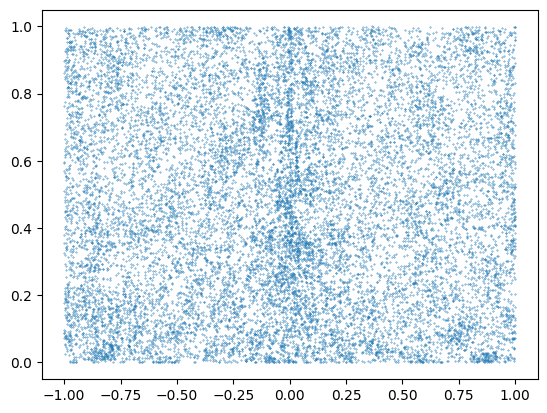

In [248]:
plt.scatter(collocation_points[:, 0], collocation_points[:, 1], s=0.1)
plt.show

Relative L2 Error: 2.798e-04


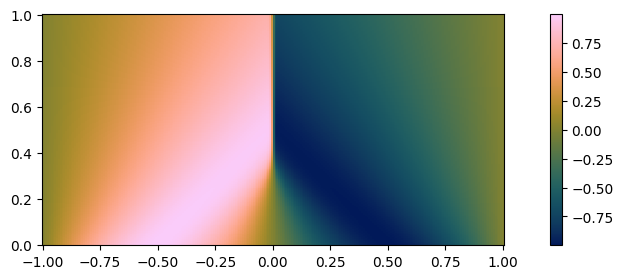

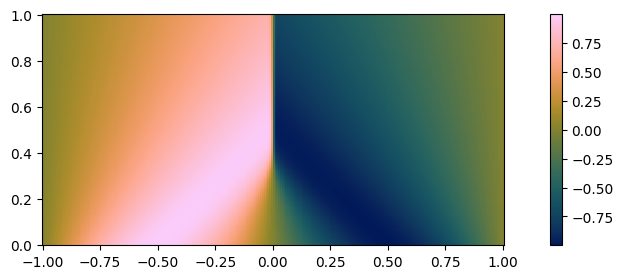

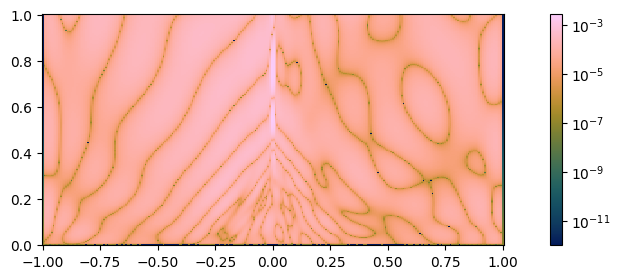

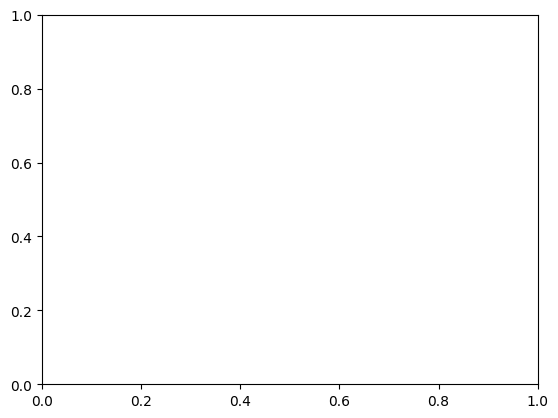

In [250]:
model = eqx.combine(params, static)

u_pred = model.predict(X, T)

error = np.abs(u_solution - u_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_sol = ax.pcolormesh(X, T, u_solution, cmap=cmap)
fig.colorbar(ax_sol, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap)
fig.colorbar(ax_nn, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots()
plt.show()

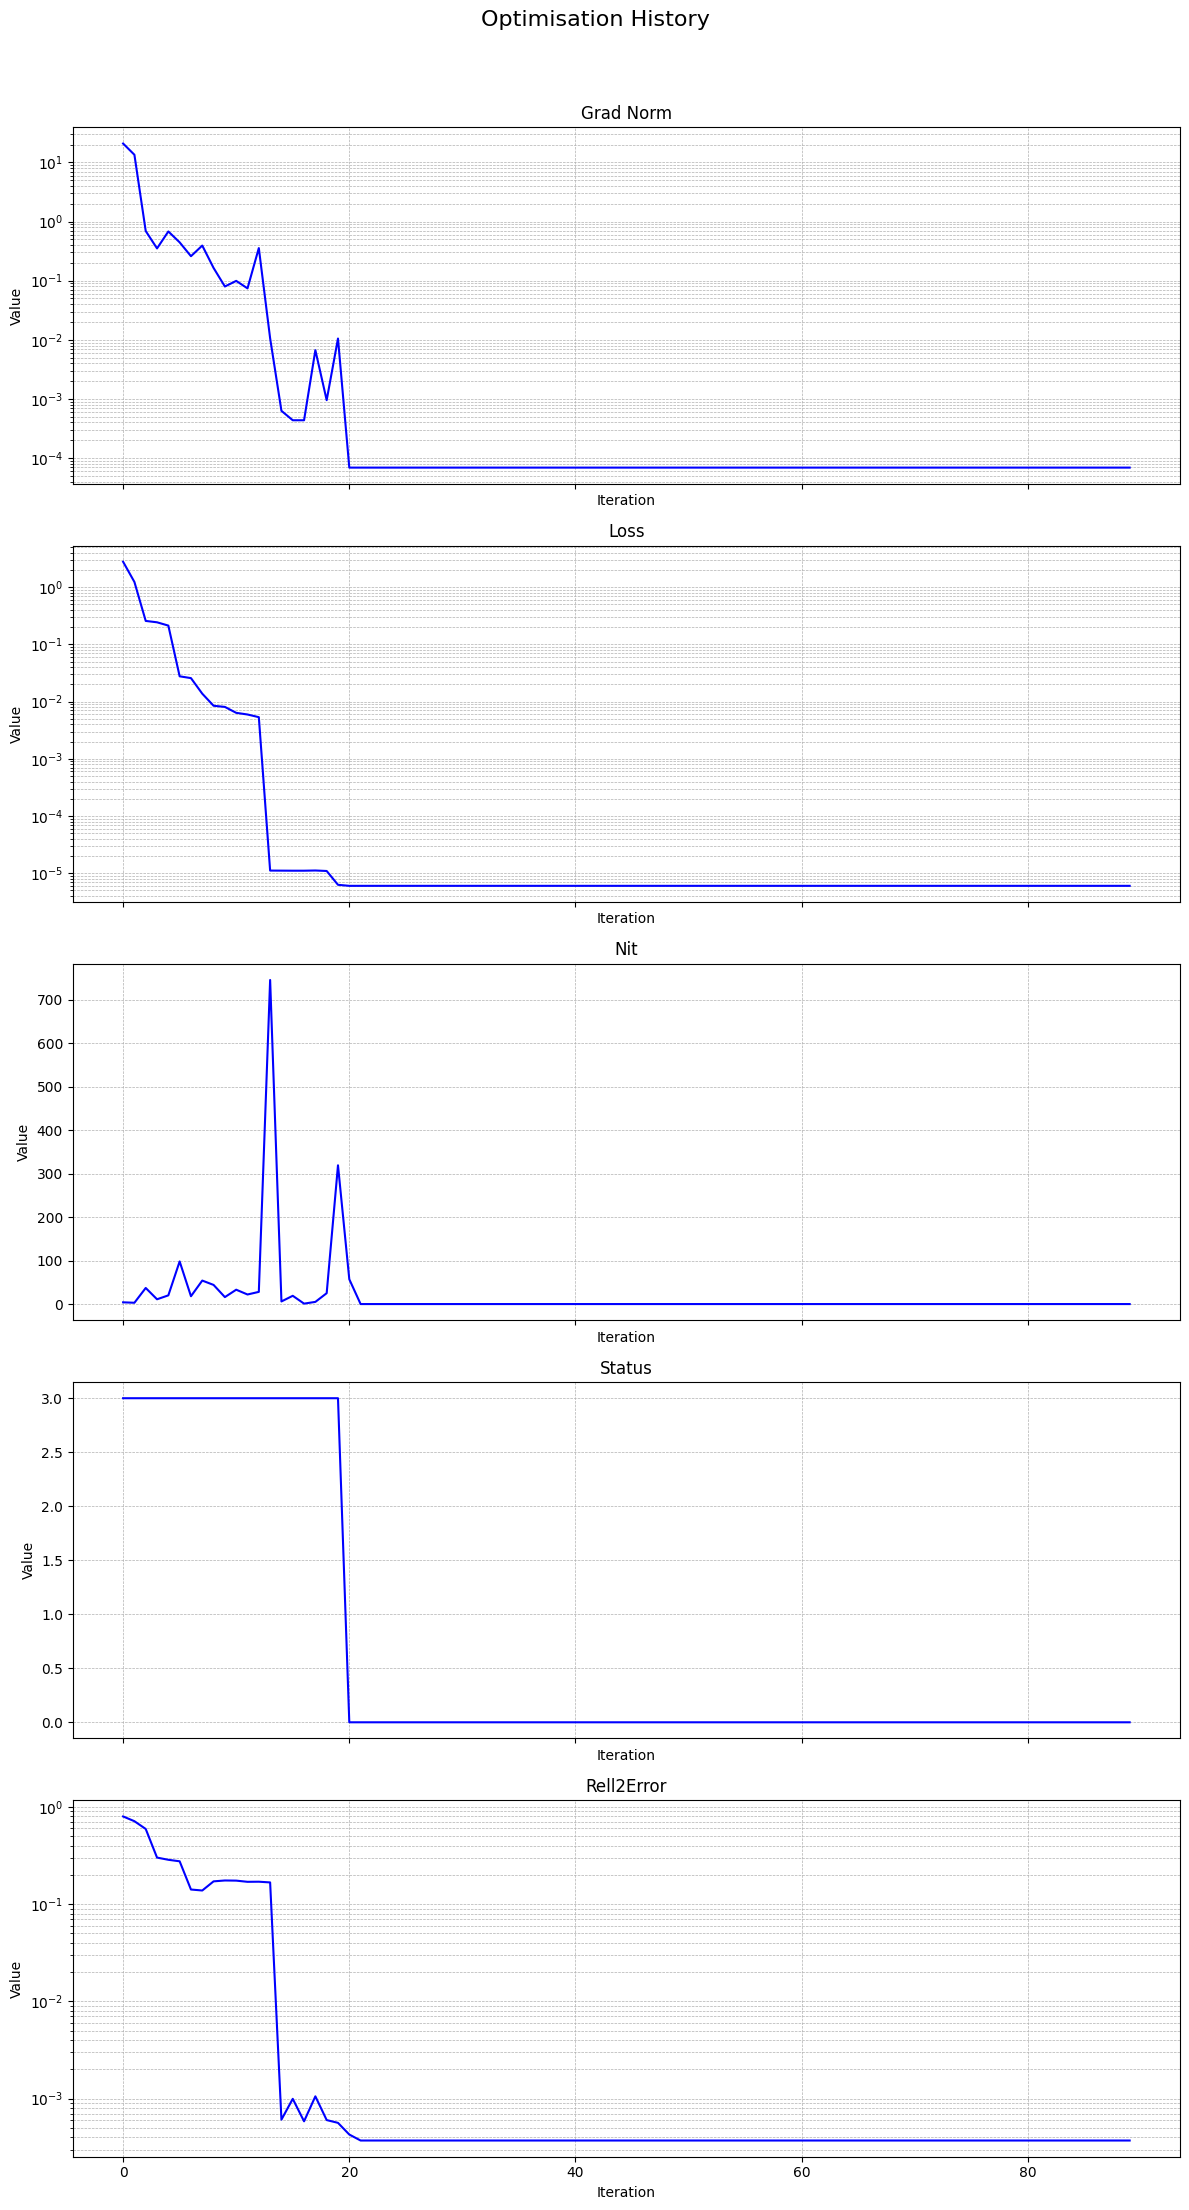

In [149]:
history.plot()

In [ ]:
import scienceplots

plt.style.use(['science', 'no-latex'])

In [ ]:
burgerslm_l2err = history.history["rell2error"][:500]
burgerslm_loss = history.history["loss"][:500]
burgerslm_lambda = history.history["lambda"][:500]
burgerslm_searchdirnorm = history.history["search_direction_norm"][:500]
burgerslm_svs = history.history["singular_values"][:500]


np.save('burgerslm_l2err.npy', burgerslm_l2err)
np.save('burgerslm_loss.npy', burgerslm_loss)
np.save('burgerslm_lambda.npy', burgerslm_lambda)
np.save('burgerslm_searchdirnorm.npy', burgerslm_searchdirnorm)
np.save('burgerslm_svs.npy', burgerslm_svs)

np.save('burgerslm_u_pred.npy', u_pred)
np.save('burgerslm_u_solution.npy', u_solution)
np.save('burgerslm_X.npy', X)
np.save('burgerslm_T.npy', T)

In [ ]:
print(np.min(burgerslm_l2err))

print(burgerslm_l2err[-1])

9.043599306804823e-07
9.557610694701962e-07


<function matplotlib.pyplot.show(close=None, block=None)>

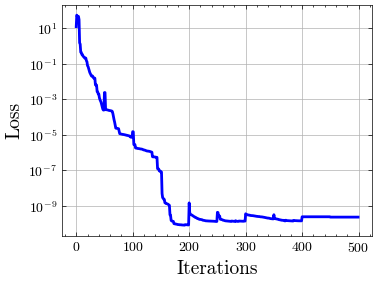

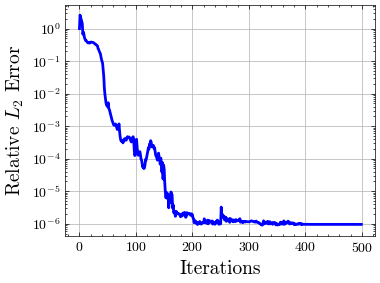

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(burgerslm_loss, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Loss', fontsize=14)
plt.grid()
plt.show

plt.figure(figsize=(4, 3))
plt.plot(burgerslm_l2err, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Relative $L_2$ Error', fontsize=14)
plt.grid()
plt.show

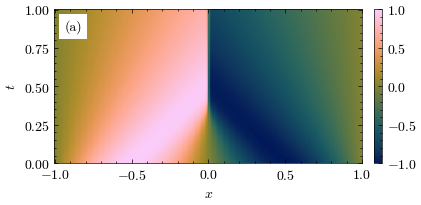

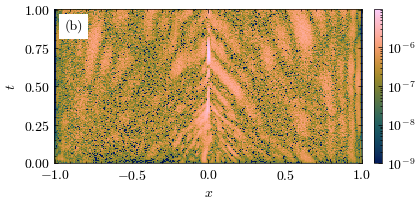

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap, rasterized=True,
                      vmin=-1,vmax=1)
fig.colorbar(ax_nn, ax=ax, pad=0.03)
ax.annotate("(a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm.pdf", format="pdf")
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-9, vmax=error.max())
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-9, norm=norm, cmap=cmap, rasterized=True,)
fig.colorbar(nn_error, ax=ax, pad=0.03)
ax.annotate("(b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm_err.pdf", format="pdf")
plt.show()